<a href="https://colab.research.google.com/github/Sonali0572/Image_Reduction/blob/main/Image_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Reduction using Auto Encoder Model


In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm
from tqdm.notebook import tqdm_notebook
import tarfile
import os

In [ ]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "/content/lfw_attributes.txt"
# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "/content/lfw-deepfunneled.tgz"
# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "/content/lfw.tgz"

In [ ]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
def load_lfw_dataset(use_raw=False,dx=80, dy=80,dimx=45, dimy=45):
# Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))
# Read photos
    all_photos = []
    photo_ids = []
# tqdm is used to show progress bar while reading the data in a notebook here, you can change
# tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
            # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})
    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')
    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)
    return all_photos, all_attrs

In [ ]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

100%|██████████| 18983/18983 [00:16<00:00, 1183.82it/s]


In [ ]:
X = X.astype('float32') / 255.0 - 0.5

In [ ]:
print(X.max(), X.min())

0.5 -0.5


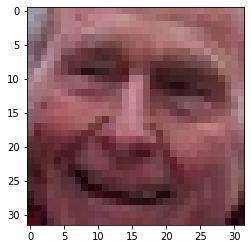

In [ ]:
import matplotlib.pyplot as plt
def show_image(x):
  plt.imshow(np.clip(x + 0.5, 0, 1))

show_image(X[10])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
def build_autoencoder(img_shape, code_size):
  # The encoder
  encoder = Sequential()
  encoder.add(InputLayer(img_shape))
  encoder.add(Flatten())
  encoder.add(Dense(code_size))
  # The decoder
  decoder = Sequential()
  decoder.add(InputLayer((code_size,)))
  decoder.add(Dense(np.prod(img_shape))) 
  # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
  decoder.add(Reshape(img_shape))
  return encoder, decoder

In [ ]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 1000)              3073000   
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         3075072   
Total params: 6,148,072
Trainable params: 6,148,072
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
370/370 [==============================] - 24s 64ms/step - loss: 0.0134 - val_loss: 0.0027
Epoch 2/10
370/370 [==============================] - 24s 66ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/10
370/370 [==============================] - 25s 68ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/10
370/370 [==============================] - 23s 62ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/10
370/370 [==============================] - 25s 68ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/10
370/370 [==============================] - 24s 64ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/10
370/370 [==============================] - 25s 68ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/10
370/370 [==============================] - 29s 78ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/10
370/370 [==============================] - 27s 72ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/10
370/370 [==============================] - 25s 67ms/step - loss: 0.001

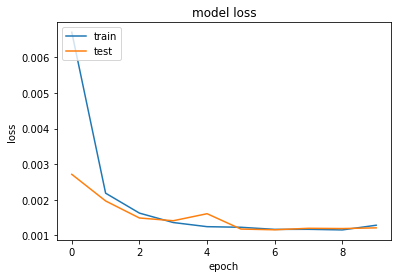

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

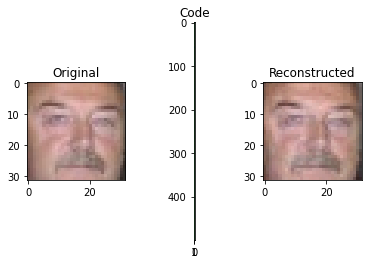

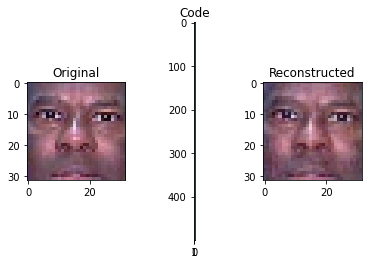

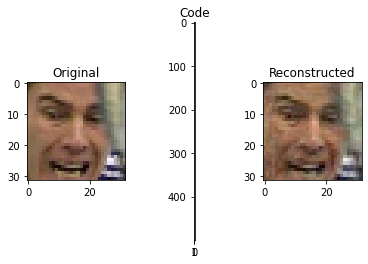

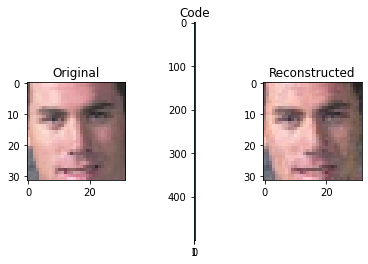

In [ ]:
def visualize(img,encoder,decoder):
  """Draws original, encoded and decoded images"""
  #img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
  code = encoder.predict(img[None])[0]
  reco = decoder.predict(code[None])[0]
  plt.subplot(1,3,1)
  plt.title("Original")
  show_image(img)
  plt.subplot(1,3,2)
  plt.title("Code")
  plt.imshow(code.reshape([code.shape[-1]//2,-1]))
  plt.subplot(1,3,3)
  plt.title("Reconstructed")
  show_image(reco)
  plt.show()
for i in range(6,10):
  img = X_test[i]
  visualize(img,encoder,decoder)